# Projet SIR
## Roussel Desmond Nzoyem

In [38]:
%reset -f

In [39]:
import numpy as np
import numpy.linalg as npalg
import pandas as pd

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import splu
from IPython.display import Image

import matplotlib.pyplot as plt

import openturns as ot
from Modules.CalibrationAnalysis import CalibrationAnalysis
import openturns.viewer
import pylab as pl

In [40]:
np.set_printoptions(precision=4, suppress=True)
plt.style.use("bmh")

## Les variables globales


Changer ces paramètres qui sont globaux, et puis relancer le notebook pour obtenir les résultats d'estimation de paramètres souhaités.


In [41]:
## Le nombre de pas de temps pour les simulation du modèle SIRD*, rajoute de la precision
stepCount = 1000

## La population totale du Cameroun au 06 mars 2020 (et puis constante)
totalPopulation = 25216237

## Début de la fenêtre d'observation le 06 mars 2020 (par exemple)
k = 44

## Taille de la fenêtre d'observation (apres 100 jours correspond au 14 juin 2020)
T = 100

## Taille de la simulation à l'intérieur de la fenêtre d'observation pour la création des données observées
## (par exemple du 06 mars au 14 juin 2020, on fait 85 observations sur 15 jours chacunes)
windowTime = 15

## PARTIE 1. Modélisation mathématique

### 1) Le modèle SIRD


Statement taken from: https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model#SIR-D-model

Compared to the standard SIR model, we are measuring the number of fatal cases and recovered cases separately. Therefore, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model, as used in SIR.

* $\mathrm{S}$: Susceptible (= Population - Confirmed)
* $\mathrm{I}$: Infected (= Confirmed - Recovered - Fatal)
* $\mathrm{R}$: Recovered
* $\mathrm{D}$: Fatal

Model:  
\begin{align*}
\mathrm{S} \overset{\beta}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\delta}{\longrightarrow} \mathrm{D}  \\
\end{align*}

- $\delta$: Mortality rate [1/min]
- $\beta$: Effective contact rate [1/min]
- $\gamma$: Recovery rate [1/min]

Ordinary Differential Equation (ODE):

\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}t}= - \frac{\beta S I}{N}  \\
& \frac{\mathrm{d}I}{\mathrm{d}t}= \frac{\beta S I}{N} - (\gamma + \delta) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}t}= \gamma I  \\
& \frac{\mathrm{d}D}{\mathrm{d}t}= \delta I  \\
\end{align*}

Where $N=S+I+R+D$ is the total population, $t$ is the elapsed time from the start date.


The virus' reproduction rate is $$\mathcal{R}_0 = \frac{\beta}{\gamma + \delta}$$

### 2) Le modèle SIRD avec natalité $\mu$ et mortalité $\nu$

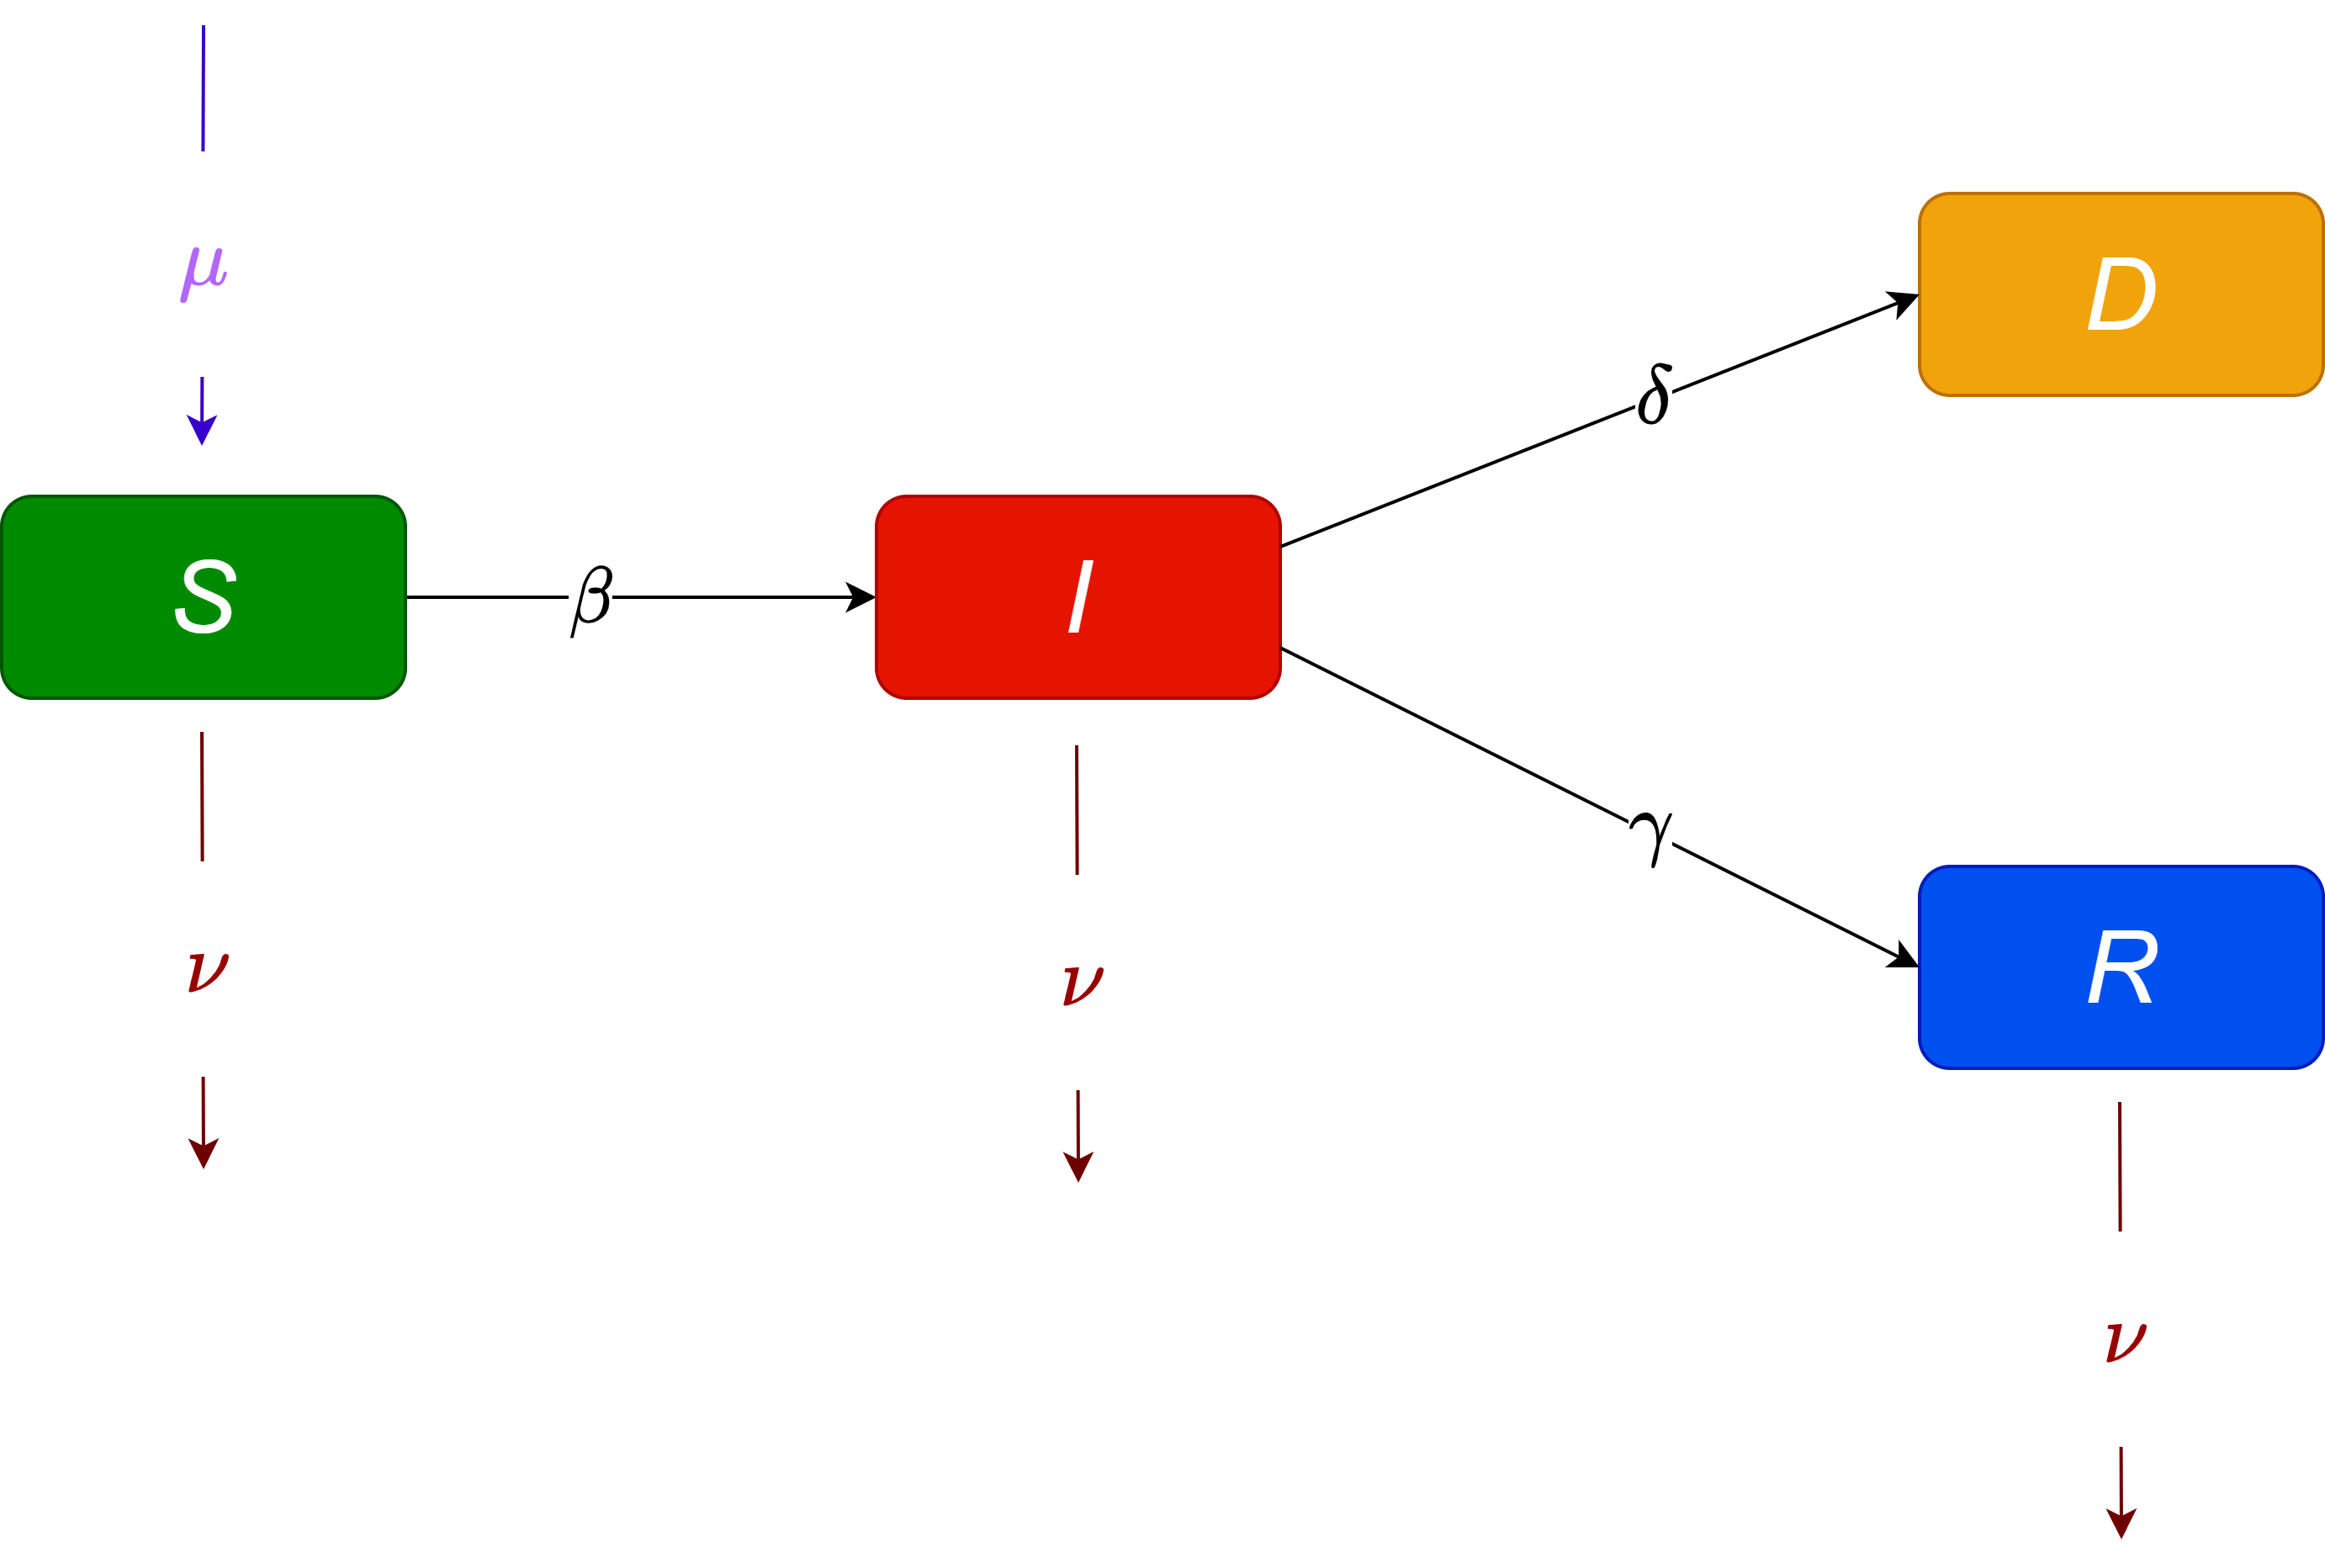

In [42]:
Image("Images/SIRD2.png", width=400)

Passage inspiré de : http://images.math.cnrs.fr/Modelisation-d-une-epidemie-partie-2.html?lang=fr

- Le taux de natalité $\mu$ de la population est aussi considéré. Les personnes sont supposées naître saines (et bien sur non décédées), on ajoute alors le terme $\mu(N-D) = \mu(S+I+R)$ à la première ligne du modele SIRD.

- On complète avec l’ajout du taux de mortalité $\nu$ de la population. Une personne pouvant décéder quelque soit son état ($S$, $I$ ou $R$) (sauf pour les morts), et de cause non liée avec l’épidémie, on retire donc ces personnes de chaque ligne (soit $−\nu S(t)$, soit $−\nu I(t)$, soit $−\nu R(t)$ selon la sous-population considérée) pour obtenir.

\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}t}= - \frac{\beta S I}{N}  + \mu (S+I+R) - \nu S \\
& \frac{\mathrm{d}I}{\mathrm{d}t}= \frac{\beta S I}{N} - (\gamma + \delta) I - \nu I \\
& \frac{\mathrm{d}R}{\mathrm{d}t}= \gamma I - \nu R \\
& \frac{\mathrm{d}D}{\mathrm{d}t}= \delta I \\
\end{align*}


#### Taux de reproduction du virus

En se focalisant sur le nombre d'infectés, on trouve

$$\mathcal{R}_0 = \frac{\beta}{\gamma + \delta + \nu}$$

Si:
 - $\mathcal{R}_0 > 1$, propagation de l'épidémie
 - $\mathcal{R}_0 \leq 1$, l'épidémie va s'arreter au bout d'un moment

#### Popualtion non constante
\begin{align*}
\frac{\mathrm{d}N}{\mathrm{d}t} &= \mu (S+I+R) -\nu (S+I+R) \\
&=  (\mu -\nu) (S+I+R)
\end{align*}

- Si $\mu > \nu$, la population totale augmente
- Si $\mu = \nu$, la population totale est constante
- Si $\mu < \nu$, la population totale diminue


### 3) Implementation du modèle et présentation des résultats

In [43]:
def modelSIRD(X0, beta, gamma, delta, mu, nu, T, stepCount):

    def func(X):
        N = np.sum(X)
        f1 = -beta*X[0]*X[1]/N + mu*(X[0]+X[1]+X[2]) - nu*X[0]
        f2 = beta*X[0]*X[1]/N - (gamma+delta)*X[1] - nu*X[1]
        f3 = gamma*X[1] - nu*X[2]
        f4 = delta*X[1]
        return np.array([f1, f2, f3, f4])

    h = T / stepCount
    Xvals = [list(X0)]

    X = X0.copy()
    for n in range(stepCount):
        k1 = func(X)
        k2 = func(X + h*k1/2.0)
        k3 = func(X + h*k2/2.0)
        k4 = func(X + h*k3)

        X += h * (k1 + 2*k2 + 2*k3 + k4) / 6.0
        Xvals.append(list(X))                   ## Evite d'utiliser les listes!

    return np.stack(Xvals)


## Une fonction pour afficher l'état du système
def plotSIRD(Xvals, ax, title, time=T, show=[0,1,2,3,4]):
    stepCount = Xvals.shape[0] - 1
    t = np.linspace(0, time, stepCount+1)
    PopTot = np.sum(Xvals, axis=1)

    if 0 in show or show is None:
        ax.plot(t, Xvals[:,0], label="Susceptibles", c='g')
    if 1 in show or show is None:
        ax.plot(t, Xvals[:,1], label="Infectés", c='r')
    if 2 in show or show is None:
        ax.plot(t, Xvals[:,2], label="Retirés", c='b')
    if 3 in show or show is None:
        ax.plot(t, Xvals[:,3], label="Décédés", c='orange')
    if 4 in show or show is None:
        ax.plot(t, PopTot, label="Population totale", c="k")

    ax.set_xlabel("Temps")
    ax.set_ylabel("Population")
    ax.set_title(title, y=1.02, size="xx-large")

    ax.legend()
    plt.tight_layout()


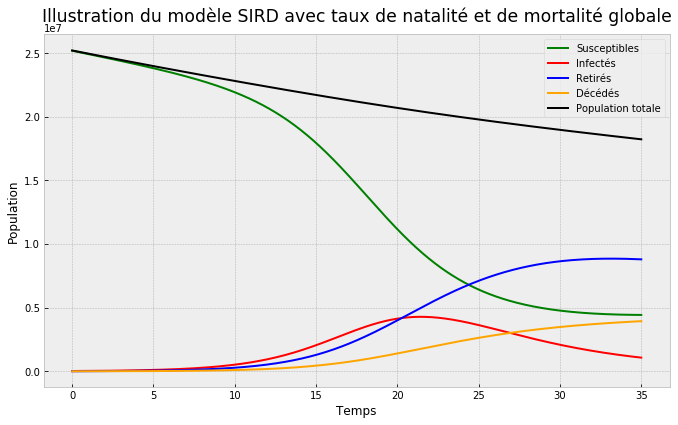

In [44]:
## Paremetres pour le modèle SIRD
S0, I0, R0, D0 = totalPopulation-2e4, 2e4, 0, 0
beta = 0.615
gamma = 0.193
delta = 0.06
mu = 0.02
nu = 0.03

## Simulation sur 35 jours
Time = 35

X0 = np.array([S0, I0, R0, D0])
modelParams = {"X0":X0, "beta":beta, "gamma":gamma, "delta":delta, "mu":mu, "nu":nu, "T":Time, "stepCount":stepCount}

Xvals = modelSIRD(**modelParams)
# print(Xvals.shape)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
plotSIRD(Xvals, ax, time=Time, title="Illustration du modèle SIRD avec taux de natalité et de mortalité globale")

# plt.savefig("Images/Simu1.png")

## PARTIE 2. Estimation des paramètres

Idées principales pour cette partie
-  Faire l’estimation des paramètres dans Openturns à partir des données observées
    - Télécharger et les traiter les donnneés à jour sur https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
    - Utiliser la fonction implementée `modelSIRD` comme une `ot.PythonFunction`
-  Faire une prediction de l'évolution du l'épidémie au Cameroun
-  Faire une analyse de sensibilité, en calculant les indices de Sobol et conclure ...


### 1) Création des entrées et des sorties dans une fenêtre donnée


#### 1) - a) Description des données téléchargées


In [45]:
def make_time_series(file_name):
    df = pd.read_csv(file_name)
    cmr = df.loc[df["Country/Region"] == "Cameroon"]

    cmrTr = cmr.transpose()
    cmrTr = cmrTr.drop(["Province/State","Country/Region","Lat",'Long'])

    return cmrTr[38]

def plot_time_series(series, figsize=(8,5), rot=45, title=None):
    series.plot(figsize=figsize, title=title, rot=rot)

def to_numpy(series, as_type=np.float64):
    return series.to_numpy(dtype=as_type)

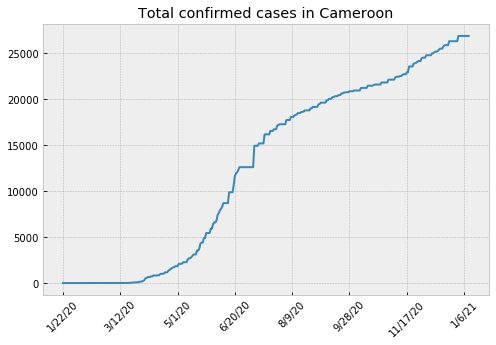

In [46]:
confirmed = make_time_series("Data/time_series_covid19_confirmed_global.csv")
plot_time_series(confirmed, title="Total confirmed cases in Cameroon")
# plt.savefig("Images/Confirmed.png")

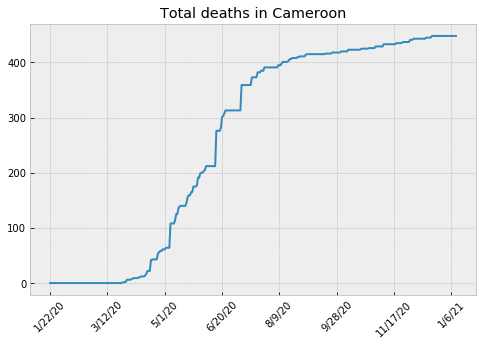

In [47]:
deaths = make_time_series("Data/time_series_covid19_deaths_global.csv")
deaths = deaths.drop(['1/11/21'])
plot_time_series(deaths, title="Total deaths in Cameroon")
# plt.savefig("Images/Deaths.png")

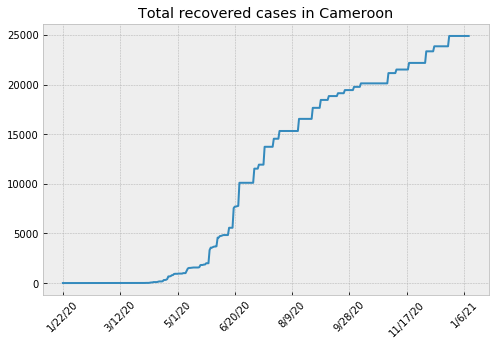

In [48]:
recovered = make_time_series("Data/time_series_covid19_recovered_global.csv")
recovered = recovered.drop(['1/11/21'])
plot_time_series(recovered, title="Total recovered cases in Cameroon")
# plt.savefig("Images/Recovered.png")


In [49]:
R = to_numpy(recovered)
D = to_numpy(deaths)
I = to_numpy(confirmed) - R - D

N = totalPopulation*np.ones_like(I)
N = N.astype(np.int64)

S = N - I - R - D

# S+I+R+D

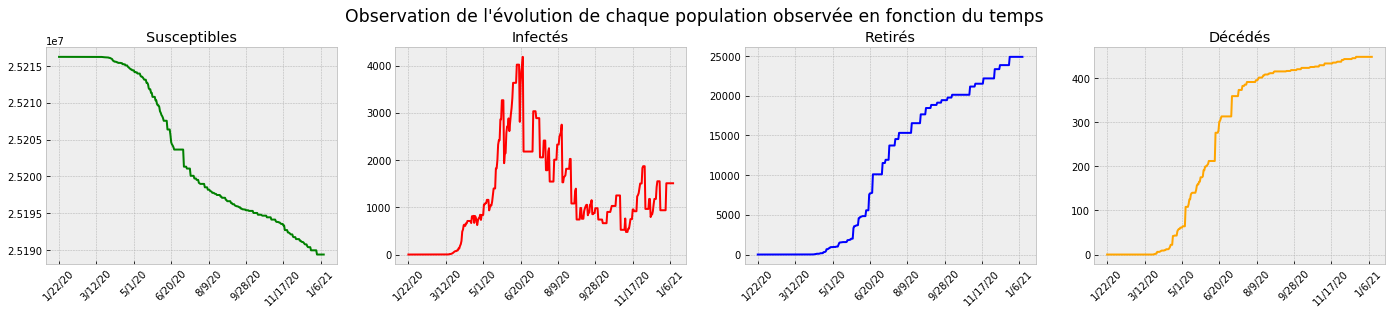

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(6*4,4))

df = pd.DataFrame(recovered)
df["Retirés"] = df[38]
df["Décédés"] = deaths
df["confirmed"] = confirmed
df["Infectés"] = df["confirmed"] - df["Décédés"] - df["Retirés"]
df["Total"] = N
df["Susceptibles"] = df["Total"] - df["Infectés"] - df["Décédés"] - df["Retirés"]

df["Susceptibles"].plot(ax=ax[0], rot=45, color='g')
df["Infectés"].plot(ax=ax[1], rot=45, color='r')
df["Retirés"].plot(ax=ax[2], rot=45, color='b')
df["Décédés"].plot(ax=ax[3], rot=45, color='orange')


ax[0].set_title("Susceptibles")
ax[1].set_title("Infectés")
ax[2].set_title("Retirés")
ax[3].set_title("Décédés")
fig.suptitle("Observation de l'évolution de chaque population observée en fonction du temps", y=1.02, size="xx-large");
# fig.savefig("Images/pretreated.png", bbox_inches="tight")


#### 1) - b) Création des données observées


In [51]:
## Localisation de la fenetre étudiée

print("Les dates sont en notation Américaine MM/JJ/AA")
print()

df = pd.DataFrame(deaths)

print("-- Debut de la fenêtre pour cette étude:", df.index[k])
print("-- Fin de la fenêtre pour cette étude:", df.index[k+T])

Les dates sont en notation Américaine MM/JJ/AA

-- Debut de la fenêtre pour cette étude: 3/6/20
-- Fin de la fenêtre pour cette étude: 6/14/20


Données initiales: [25215728.      484.       17.        8.]

Données obtenues : [25209948.     1300.     4969.       20.]
Données observées: [25215220.      818.      177.       22.]


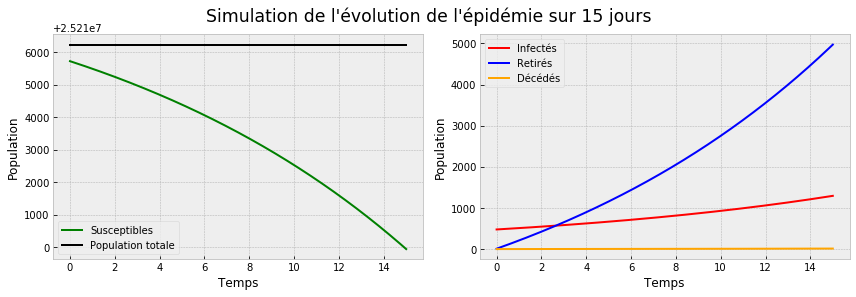

In [52]:
## Petit test de comparaison entre les données observées et notre modele SIRD

## Calibrage à la main sur une seule simulation (ces valeurs vont constituer le "prior" lors de l'estimation de paramtres)
beta = 0.467
gamma = 0.4
delta = 0.001

mu = 0.0001
nu = 0.0001

k_ = (k+T)//2
Time = windowTime

X0 = np.array([S[k_], I[k_], R[k_], D[k_]])
modelParams = {"X0":X0, "beta":beta, "gamma":gamma, "delta":delta, "mu":mu, "nu":nu, "T":Time, "stepCount":stepCount}

Xvals = modelSIRD(**modelParams)

fig, ax = plt.subplots(1, 2, figsize=(6*2,4))
plotSIRD(Xvals, ax[0], time=Time, title=None, show=[0,4])
plotSIRD(Xvals, ax[1], time=Time, title=None, show=[1,2,3])
fig.suptitle("Simulation de l'évolution de l'épidémie sur "+str(Time)+" jours", size="xx-large", y=1.02)

obtained = np.round(Xvals[-1], 0)
observed = np.array([S[k_+Time], I[k_+Time], R[k_+Time], D[k_+Time]])

# print()
print("Données initiales:", X0)
print()
print("Données obtenues :", obtained)
print("Données observées:", observed)

In [53]:
## Construction des sample observés
def makeSample(S, I, R, D, windowTime=15):
    totalLength = len(S)
    # print(windowTime, totalLength)
    assert windowTime <= totalLength ## by taking wondows of size 1

    sampleSize = totalLength - windowTime

    inputs = np.zeros((sampleSize, 4))
    outputs = np.zeros((sampleSize, 4))

    for k in range(sampleSize):
        inputs[k] = np.array([S[k], I[k], R[k], D[k]])
        k_ = k + windowTime
        outputs[k] = np.array([S[k_], I[k_], R[k_], D[k_]])

    return inputs, outputs

inputs, observedOutputs = makeSample(S[k:k+T], I[k:k+T], R[k:k+T], D[k:k+T], windowTime)
print("Shapes")
print("Observed inputs: ", inputs.shape)
print("Observed outputs:", observedOutputs.shape)

inputs, observedOutputs = ot.Sample(inputs), ot.Sample(observedOutputs)

varDescription = ["Suceptibles", "Infectés", "Retirés", "Décédés"]
inputs.setDescription(varDescription)
observedOutputs.setDescription(varDescription)

# display(inputs, observedOutputs)

Shapes
Observed inputs:  (85, 4)
Observed outputs: (85, 4)


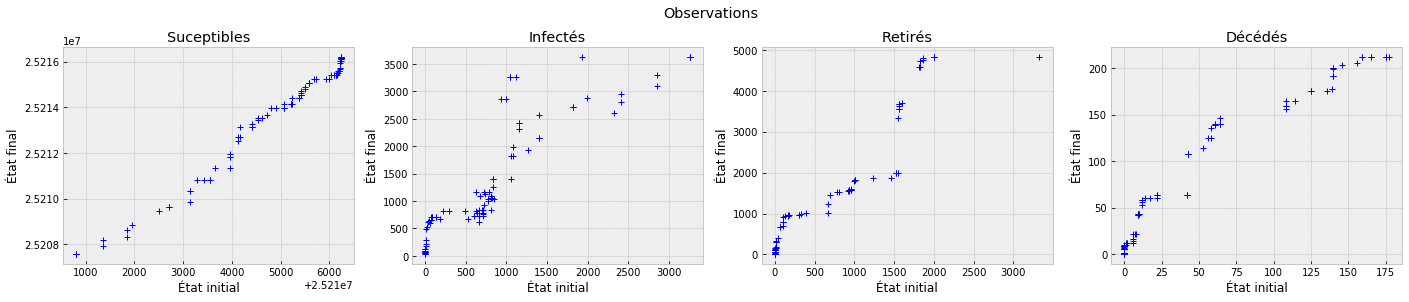

In [54]:
colors = ['green', 'red', 'blue', 'orange']
fig = pl.figure(figsize=(6*4, 4))
for i in range(4):
    graph = ot.Graph("","État initial","État final",True)
    cloud = ot.Cloud(inputs[:, i],observedOutputs[:, i])
    # cloud.setColor(colors[i])
    graph.add(cloud)
    ax = fig.add_subplot(1, 4, i + 1)
    ax.set_title(varDescription[i])
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])
fig.suptitle("Observations", y=1.02, size="x-large");
# fig.savefig("Images/treated.png", bbox_inches="tight")

### 2) Estimation des paramètres par calage

In [55]:
## Simulateur Openturns
def simulatorSIRD(X):
    S0, I0, R0, D0, beta, gamma, delta, mu, nu = X
    Xvals = modelSIRD(np.array([S0, I0, R0, D0]), beta, gamma, delta, mu, nu, windowTime, stepCount)
    return np.round(Xvals[-1], 0)


In [56]:
myFunc = ot.PythonFunction(9, 4, simulatorSIRD)
myFunc.setOutputDescription(varDescription)

#
## Definition du Prior:
### les varaiblles beta, gamma, delta, et mu on eté calibrées a la main plus haut
prior = ot.Point([beta,gamma,delta,mu,nu])

calIndices = [4,5,6,7,8]
calFunc = ot.ParametricFunction(myFunc, calIndices, prior)

## Calage lineaire
algo = ot.LinearLeastSquaresCalibration(calFunc, inputs, observedOutputs, prior, "SVD")

## Calibrage non lineaires
# algo = ot.NonLinearLeastSquaresCalibration(calFunc, inputs, observedOutputs, prior)
# algo.setBootstrapSize(0)

## Maximum de vraissamblance
# https://openturns.github.io/openturns/master/examples/statistical_estimation/maximumlikelihood_estimator.html

algo.run()
calResults = algo.getResult()

In [57]:
# # Parameters for Gaussian calibration
# priorCovariance = ot.CovarianceMatrix(5)
# priorCovariance[0,0] = (0.1*beta)**2
# priorCovariance[1,1] = (0.1*gamma)**2
# priorCovariance[2,2] = (0.1*delta)**2
# priorCovariance[3,3] = (0.1*mu)**2
# priorCovariance[4,4] = (0.1*nu)**2
#
# errorCovariance = ot.CovarianceMatrix(4)
# errorCovariance[0,0] = 1e6
# errorCovariance[1,1] = 100
# errorCovariance[2,2] = 10
# errorCovariance[3,3] = 2
#
# ## Calage gaussien lineaire : la fonction est linéarisée autour du prior
# algo = ot.GaussianLinearCalibration(calFunc, inputs, observedOutputs, prior, priorCovariance, errorCovariance, "SVD")

## Calage gaussien non lineaire : la matrice de covariance est fixée
# algo = ot.GaussianNonLinearCalibration(calFunc, inputs, observedOutputs, prior, priorCovariance, errorCovariance)

# algo.run()
# calResults = algo.getResult()

In [58]:
resMAP = calResults.getParameterMAP()       ## Maximum mode of the posterior distribution
print("Mode of the posterior estimation:\n", resMAP)
print()

post = calResults.getParameterPosterior()
print("Posterior esimations:\n", post)
print()

interval = post.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]
print("Confidence interval:\n", interval)

Mode of the posterior estimation:
 [0.450291,0.367021,0.00569608,0.05649,0.0564913]

Posterior esimations:
 Normal(mu = [0.450291,0.367021,0.00569608,0.05649,0.0564913], sigma = [0.00405957,0.00414502,0.00277589,0.0018583,0.00185835], R = 5x5
[[  1          0.570498   0.234964   0.524789   0.524763  ]
 [  0.570498   1         -0.279318  -0.0712166 -0.0711927 ]
 [  0.234964  -0.279318   1         -0.216091  -0.216133  ]
 [  0.524789  -0.0712166 -0.216091   1          1         ]
 [  0.524763  -0.0711927 -0.216133   1          1         ]])

Confidence interval:
 [0.419233, 0.481349]
[0.335309, 0.398733]
[-0.0155412, 0.0269334]
[0.0422728, 0.0707071]
[0.0422738, 0.0707089]


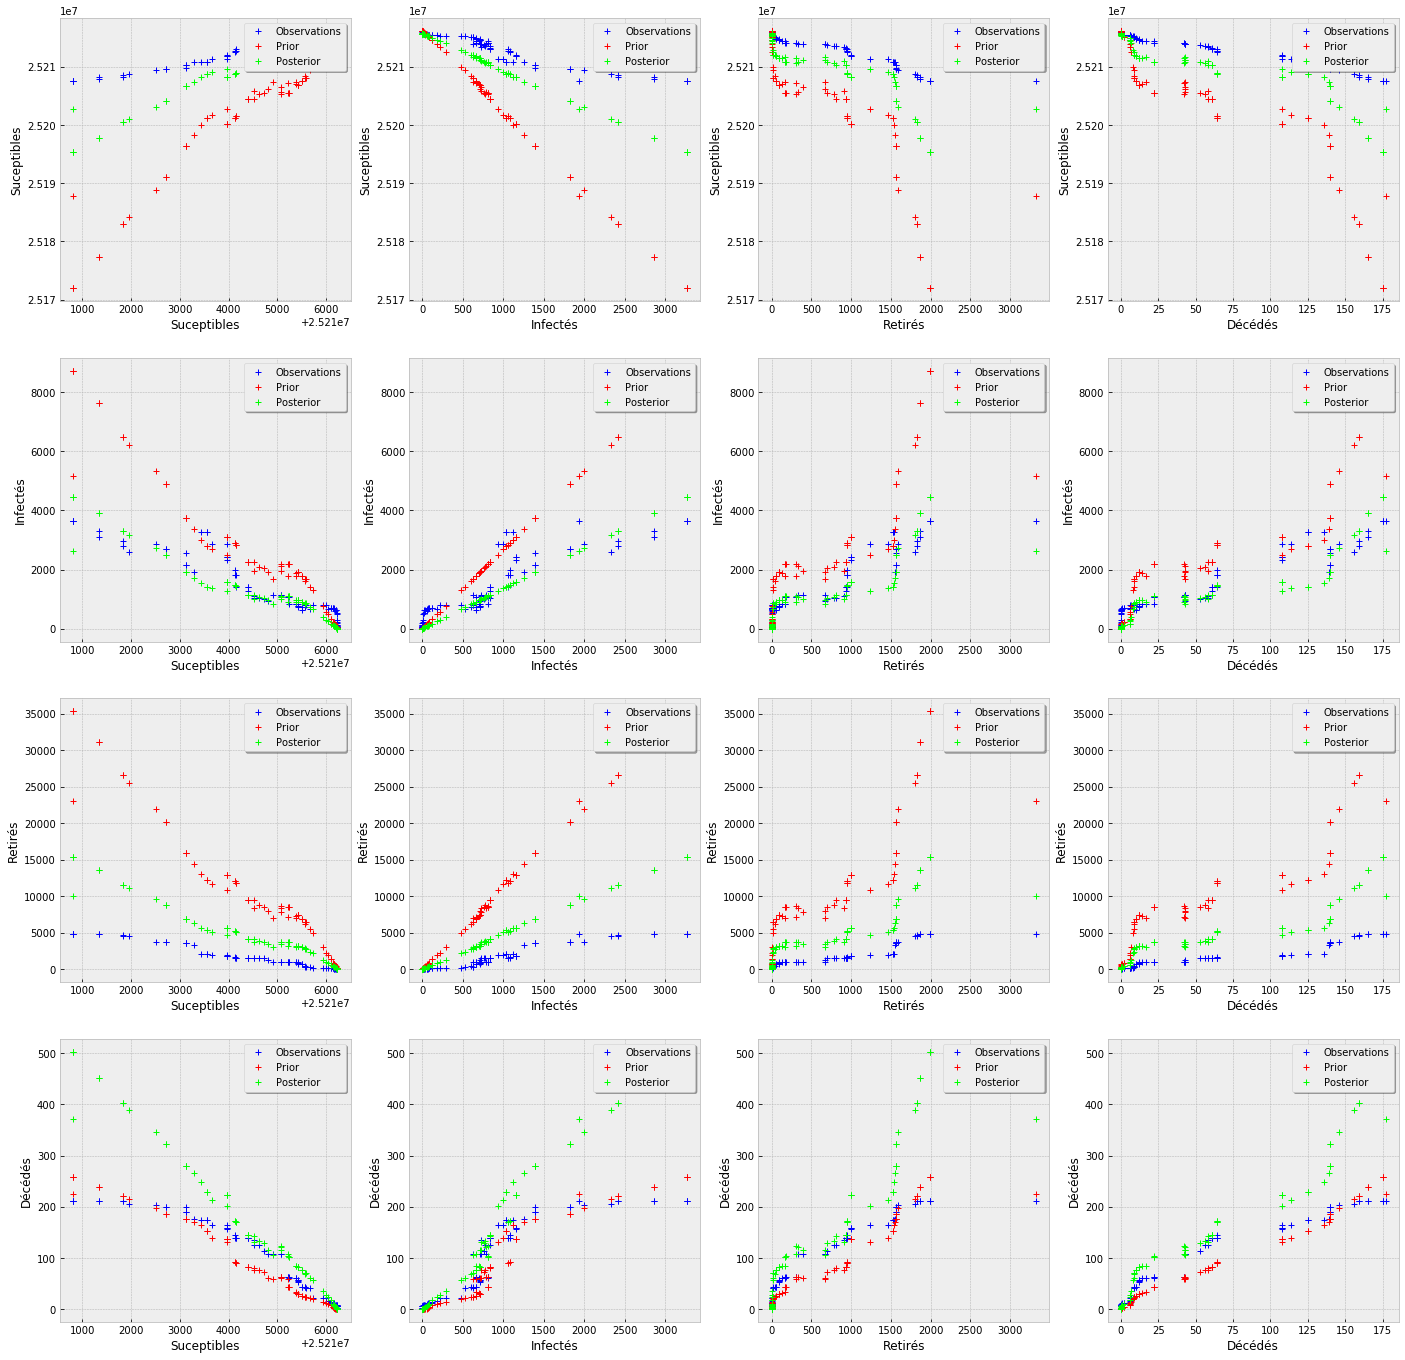

In [59]:
calAna = CalibrationAnalysis(calResults, calFunc, inputs, observedOutputs)

graph = calAna.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
# graph.setYTitle("Final State")

# view = ot.viewer.View(graph)
# view.save("Images/priorpost.png")

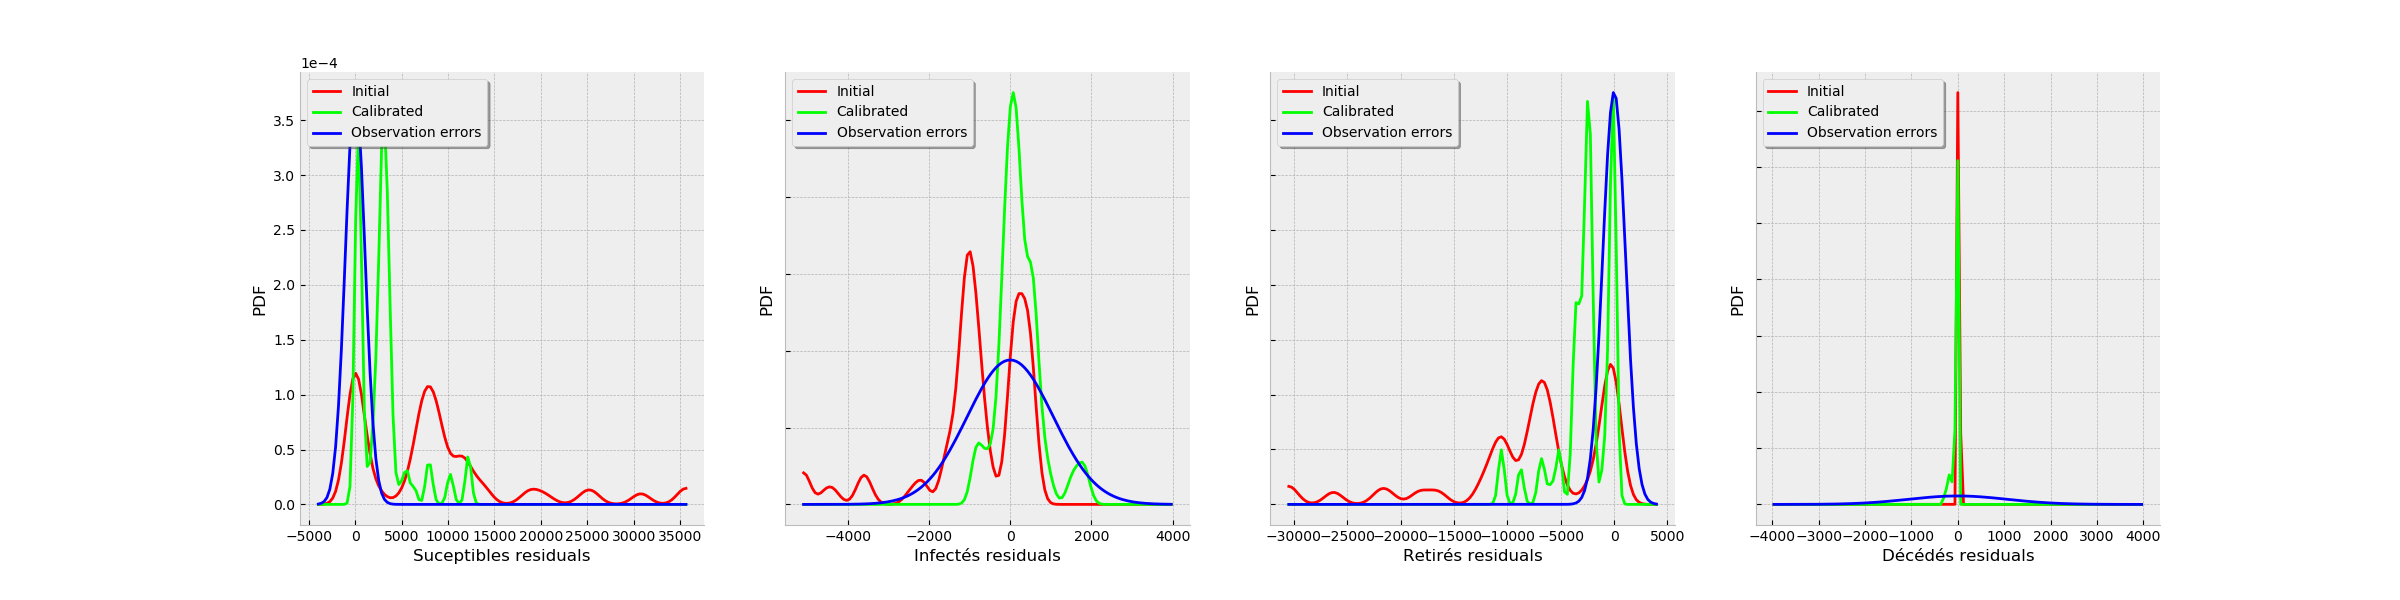

In [60]:
## Observation des erreurs residuelles pour chaque sortie

observationError = calResults.getObservationsError()
# observationError

graph = calResults.drawResiduals()
graph.setLegendPosition("topleft")
graph

### 3) Prédiction de l'évolution de la maladie


#### 3) - a) Distribution de $R_0$


A partir d'ici, on suppose que les lois sont indépendantes, non correllées, on extrait donc les marginales de la distribution qui a été prescrite comme posterior.

In [61]:
##
# On connait les parametres des lois autres parametres: tous des lois normales apres ajustement
distBeta = post.getMarginal(0)
distBeta.setDescription(["Beta"])
distGamma = post.getMarginal(1)
distGamma.setDescription(["Gamma"])
distDelta = post.getMarginal(2)
distDelta.setDescription(["Delta"])
distMu = post.getMarginal(3)
distMu.setDescription(["Mu"])
distNu = post.getMarginal(4)
distNu.setDescription(["Nu"])

print("Les lois pour les paramètres estimés:")
print("-- beta : ", distBeta)
print("-- gamma: ", distGamma)
print("-- delta: ", distDelta)
print("-- mu:    ", distMu)
print("-- nu:    ", distNu)

Les lois pour les paramètres estimés:
-- beta :  Normal(mu = 0.450291, sigma = 0.00405957)
-- gamma:  Normal(mu = 0.367021, sigma = 0.00414502)
-- delta:  Normal(mu = 0.00569608, sigma = 0.00277589)
-- mu:     Normal(mu = 0.05649, sigma = 0.0018583)
-- nu:     Normal(mu = 0.0564913, sigma = 0.00185835)


Taux de reproduction:

Districution:  ProductDistribution(Normal(mu = 0.450291, sigma = 0.00405957) * CompositeDistribution=f(Normal(mu = 0.429208, sigma = 0.00532355)) with f=[x]->[1.0 / x])

Moyenne:       [1.04928]
Ecart type:    [0.0160945]

Probabilité de dépassement de 1: 0.9991811292918611



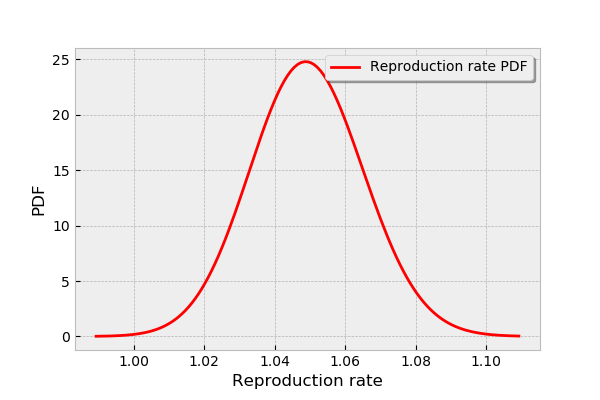

In [62]:
distR0 = distBeta / (distGamma + distDelta + distNu)
distR0.setDescription(["Reproduction rate"])

print("Taux de reproduction:")
print()
print("Districution: ", distR0)
print()
print("Moyenne:      ", distR0.getMean())
print("Ecart type:   ", distR0.getStandardDeviation())

print()
virusSpread = distR0.computeComplementaryCDF(1)
print("Probabilité de dépassement de 1:", virusSpread)
print()

distR0.drawPDF()

#### 3) - b) Simulation de l'évolution de la maladie


Initial condition: [25207556.     3633.     4836.      212.]

Obtained output  : [25191938.     4962.    18251.      576.]
Observed output  : [25203645.     2179.    10100.      313.]


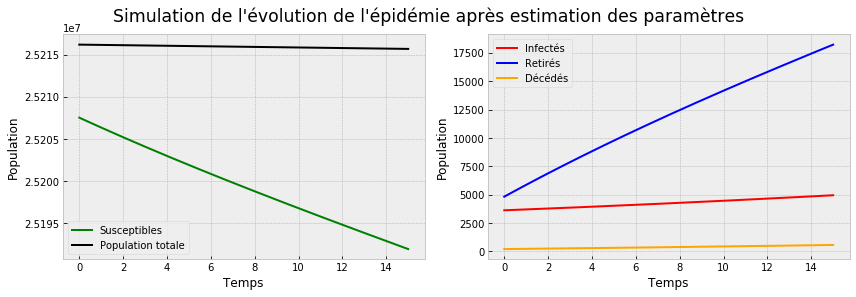

In [63]:
beta = resMAP[0]
gamma = resMAP[1]
delta = resMAP[2]
mu = resMAP[3]
nu = resMAP[4]

k_ = k+T
T_ = 1*windowTime

X0 = np.array([S[k_], I[k_], R[k_], D[k_]])
modelParams = {"X0":X0, "beta":beta, "gamma":gamma, "delta":delta, "mu":mu, "nu":nu, "T":T_, "stepCount":stepCount}

Xvals = modelSIRD(**modelParams)

fig, ax = plt.subplots(1, 2, figsize=(6*2,4))
plotSIRD(Xvals, ax[0], time=T_, title=None, show=[0,4])
plotSIRD(Xvals, ax[1], time=T_, title=None, show=[1,2,3])
# plotSIRD(Xvals, ax[2], title=None, show=[0,1,2,3,4])
fig.suptitle("Simulation de l'évolution de l'épidémie après estimation des paramètres", y=1.02, size="xx-large")
# fig.savefig("Images/predict.png", bbox_inches="tight")

obtained = np.round(Xvals[-1], 0)
observed = np.array([S[k_+T_], I[k_+T_], R[k_+T_], D[k_+T_]])

print()
print("Initial condition:", X0)
print()
print("Obtained output  :", obtained)
print("Observed output  :", observed)

### 4) Estimer les paramètres des lois de S, I, R, et D en fonction du temps


On utilise notre intuition pour savoir quelles lois marchent mieux. Nous utiliserons ces lois pour l'analyse de sensibilité à suivre.


In [64]:
## Utilisons les paramtres estimés

graphs = []

start = k
end = k+T

dataS = ot.Sample(S[start:end,np.newaxis])
dataS.setDescription(["Susceptibles"])
distS = ot.BetaFactory().build(dataS)
distS.setDescription(["S"])
graphs.append(ot.VisualTest.DrawQQplot(dataS, distS))

dataI = ot.Sample(I[start:end,np.newaxis])
dataI.setDescription(["Infectés"])
# distI = ot.NormalFactory().build(dataI)
distI = ot.BetaFactory().build(dataI)
distI.setDescription(["I"])
graphs.append(ot.VisualTest.DrawQQplot(dataI, distI))

dataR = ot.Sample(R[start:end,np.newaxis])
dataR.setDescription(["Retirés"])
distR = ot.BetaFactory().build(dataR)
distR.setDescription(["R"])
graphs.append(ot.VisualTest.DrawQQplot(dataR, distR))

dataD = ot.Sample(D[start:end,np.newaxis])
dataD.setDescription(["Décédés"])
distD = ot.BetaFactory().build(dataD)
distD.setDescription(["D"])
graphs.append(ot.VisualTest.DrawQQplot(dataD, distD))

print("Les lois pour les paramètres initiaux:")
print("-- S:", distS)
print("-- I:", distI)
print("-- R:", distR)
print("-- D:", distD)

Les lois pour les paramètres initiaux:
-- S: Beta(alpha = 0.945984, beta = 0.372068, a = 2.52075e+07, b = 2.52163e+07)
-- I: Beta(alpha = 0.477746, beta = 1.01054, a = -34.6078, b = 3668.61)
-- R: Beta(alpha = 0.25275, beta = 0.759881, a = -47.4118, b = 4883.41)
-- D: Beta(alpha = 0.285033, beta = 0.49666, a = -2.07843, b = 214.078)


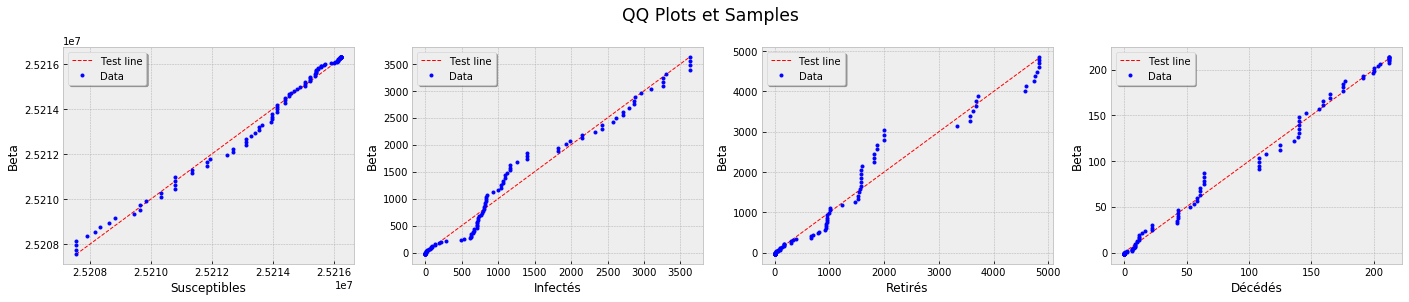

In [65]:
labels = [distS.getName(), distI.getName(), distR.getName(), distD.getName()]
fig = pl.figure(figsize=(6*4, 4))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    # ax.set_ylabel("Normal")
    graphs[i].setYTitle(labels[i])
    _ = ot.viewer.View(graphs[i], figure=fig, axes=[ax])
fig.suptitle("QQ Plots et Samples", y=1.02, size="xx-large");
# fig.savefig("Images/qqplots.png", bbox_inches="tight")

### 5) Analyse de sensibilité


In [66]:
X = ot.ComposedDistribution([distS, distI, distR, distD, distBeta, distGamma, distDelta, distMu, distNu])

## Simulateur Openturns pour S
def simulatorS(X):
    S0, I0, R0, D0, beta, gamma, delta, mu, nu = X
    Xvals = modelSIRD(np.array([S0, I0, R0, D0]), beta, gamma, delta, mu, nu, windowTime, stepCount)
    Y = ot.Point(1)
    Y[0] = np.round(Xvals[-1, 0], 0)
    return Y
myFuncS = ot.PythonFunction(9, 1, simulatorS)
myFuncS.setOutputDescription(["Susceptibles"])

## Simulateur Openturns pour I
def simulatorI(X):
    S0, I0, R0, D0, beta, gamma, delta, mu, nu = X
    Xvals = modelSIRD(np.array([S0, I0, R0, D0]), beta, gamma, delta, mu, nu, windowTime, stepCount)
    Y = ot.Point(1)
    Y[0] = np.round(Xvals[-1, 1], 0)
    return Y
myFuncI = ot.PythonFunction(9, 1, simulatorI)
myFuncI.setOutputDescription(["Infectés"])

## Simulateur Openturns pour I
def simulatorR(X):
    S0, I0, R0, D0, beta, gamma, delta, mu, nu = X
    Xvals = modelSIRD(np.array([S0, I0, R0, D0]), beta, gamma, delta, mu, nu, windowTime, stepCount)
    Y = ot.Point(1)
    Y[0] = np.round(Xvals[-1, 2], 0)
    return Y
myFuncR = ot.PythonFunction(9, 1, simulatorR)
myFuncR.setOutputDescription(["Retirés"])

## Simulateur Openturns pour D
def simulatorD(X):
    S0, I0, R0, D0, beta, gamma, delta, mu, nu = X
    Xvals = modelSIRD(np.array([S0, I0, R0, D0]), beta, gamma, delta, mu, nu, windowTime, stepCount)
    Y = ot.Point(1)
    Y[0] = np.round(Xvals[-1, 3], 0)
    return Y
myFuncD = ot.PythonFunction(9, 1, simulatorD)
myFuncD.setOutputDescription(["Décédés"])

#### 4) - a) Par développement de Taylor


In [67]:

def TalorAnalysis(func, description):
    Y = ot.CompositeRandomVector(func, ot.RandomVector(X))
    Y.setDescription([description])

    # sens = ot.SimulationSensitivityAnalysis(Y)
    taylor = ot.TaylorExpansionMoments(Y)

    importancefactors = taylor.getImportanceFactors()
    print(description+":")
    print("Importance factors:", importancefactors)
    print()
    # sens.drawImportanceFactors()

    return taylor.drawImportanceFactors()

In [68]:
graphs = []
description = []

try:
    taylorS = TalorAnalysis(myFuncS, "Susceptibles")
    graphs.append(taylorS)
    description.append(varDescription[0])
except:
    print("Erreur de NaN\n")

try:
    taylorI = TalorAnalysis(myFuncI, "Infectés")
    graphs.append(taylorI)
    description.append(varDescription[1])
except:
    print("Erreur de NaN\n")

try:
    taylorR = TalorAnalysis(myFuncR, "Retirés")
    graphs.append(taylorR)
    description.append(varDescription[2])
except:
    print("Erreur de NaN\n")

try:
    taylorD = TalorAnalysis(myFuncD, "Décédés")
    graphs.append(taylorD)
    description.append(varDescription[3])
except:
    print("Erreur de NaN\n")

Susceptibles:
Importance factors: [S : 0, I : 0, R : 0, D : 0, Beta : 1.66818e-07, Gamma : 1.73915e-07, Delta : 1.94997e-08, Mu : 0.500117, Nu : 0.499882]

Infectés:
Importance factors: [S : 0, I : 0, R : 0, D : 0, Beta : 0.367693, Gamma : 0.383335, Delta : 0.171921, Mu : 0, Nu : 0.0770514]

Retirés:
Importance factors: [S : 0, I : 0, R : 0, D : 0, Beta : 0.433692, Gamma : 0, Delta : 0.202781, Mu : 0, Nu : 0.363527]

Décédés:
Importance factors: [S : 0, I : 0, R : 0, D : 0, Beta : 0, Gamma : 0, Delta : 1, Mu : 0, Nu : 0]



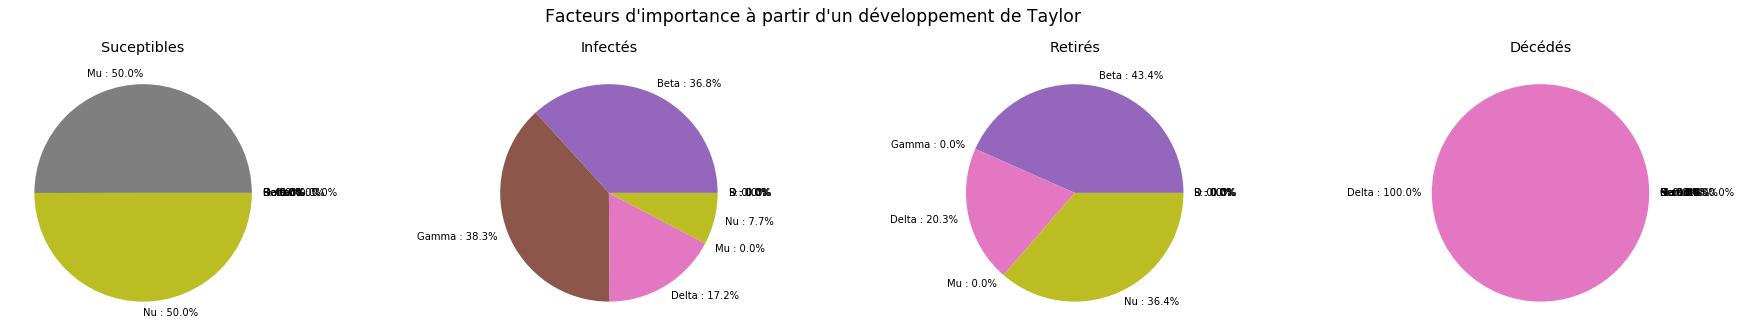

In [69]:
lenGraphs = len(graphs)

fig = pl.figure(figsize=(8*lenGraphs, 5))
for i in range(lenGraphs):
    ax = fig.add_subplot(1, lenGraphs, i + 1)
    ax.set_title(description[i], size="x-large")
    _ = ot.viewer.View(graphs[i], figure=fig, axes=[ax])
fig.suptitle("Facteurs d'importance à partir d'un développement de Taylor", y=1.02, size="xx-large");
# fig.savefig("Images/taylor.png", bbox_inches="tight")

#### 4) - b) Indices de Sobol


In [70]:
## Avec un buget fixé

def SobolAnalysis(func, description=None, size=50):

    sie = ot.SobolIndicesExperiment(X, size, False)
    inputDesign = sie.generate()

    outputDesign = func(inputDesign)

    sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
    sensitivityAnalysis.setUseAsymptoticDistribution(True)

    fo = sensitivityAnalysis.getFirstOrderIndices()
    to = sensitivityAnalysis.getTotalOrderIndices()

    print(description+":")
    print("First order: %s" % (str(fo)))
    print("Total order: %s" % (str(to)))
    print()

    return sensitivityAnalysis

In [71]:
anaS = SobolAnalysis(myFuncS, "Susceptibles" , size=50)

anaI = SobolAnalysis(myFuncI, "Infectés", size=50)

anaR = SobolAnalysis(myFuncR, "Retirés", size=50)

anaD = SobolAnalysis(myFuncD, "Décédés", size=50)

Susceptibles:
First order: [-0.00264109,-0.00231111,-0.00256583,-0.00269413,-0.00271692,-0.00274176,-0.00269986,0.729485,0.84002]
Total order: [-0.000712801,-0.00171953,0.000320406,-6.53859e-05,-4.94988e-05,-0.000114007,-0.000100982,0.411986,0.615204]

Infectés:
First order: [-0.0223592,1.09137,-0.0225861,-0.0223552,-0.0414012,-0.0474445,-0.0104166,-0.0223655,-0.00916552]
Total order: [-8.04362e-06,1.00596,6.36294e-06,1.08091e-05,0.0162629,0.00704947,0.0223335,3.38689e-05,-0.0233995]

Retirés:
First order: [-0.00364188,1.12032,0.0694358,-0.00365377,0.010645,-0.00233587,-0.00138018,-0.00364156,-0.00597121]
Total order: [-2.44451e-05,0.988792,0.0341664,-3.83305e-05,-0.00285868,-0.00647086,0.00189476,-1.77787e-05,0.00319073]

Décédés:
First order: [-0.000268522,0.793518,-0.000268522,0.299194,0.00223127,0.00726018,0.171171,-0.000268522,-0.00358648]
Total order: [-0.000178763,0.590014,-0.000178763,0.347515,-0.0110284,-0.0106714,0.344385,-0.000178763,-0.00318547]



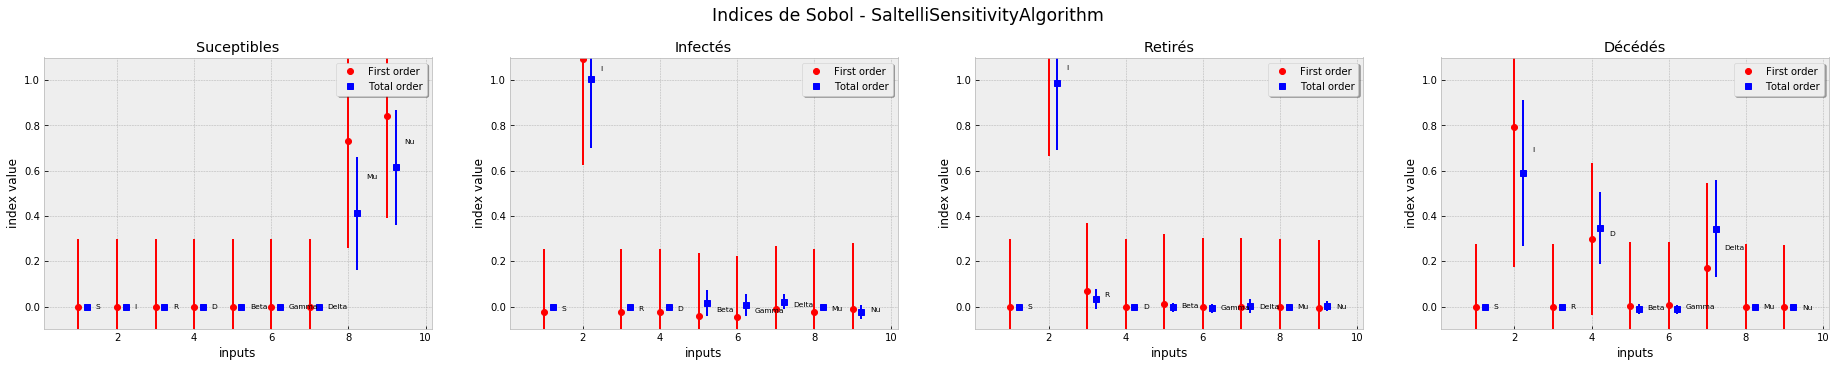

In [72]:
graphs = [anaS.draw(), anaI.draw(), anaR.draw(), anaD.draw()]
fig = pl.figure(figsize=(8*4, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.set_title(varDescription[i])
    _ = ot.viewer.View(graphs[i], figure=fig, axes=[ax])
fig.suptitle("Indices de Sobol - SaltelliSensitivityAlgorithm", y=1.02, size="xx-large");
# fig.savefig("Images/sobol.png", bbox_inches="tight")

In [73]:
## Algorithme itératif

# alpha = 0.05 # i.e. 95% confidence interval
# epsilon = 0.2 # Confidence interval length
# blockSize = 50 # size of Sobol experiment at each iteration
# batchSize = 16 # number of points evaluated simultaneously
#
# estimator = ot.SaltelliSensitivityAlgorithm()
# estimator.setUseAsymptoticDistribution(True)
# algo = ot.SobolSimulationAlgorithm(X, myFuncI, estimator)
#
# algo.setMaximumOuterSampling(2) # number of iterations
# algo.setBlockSize(blockSize)
# algo.setBatchSize(batchSize)
# algo.setIndexQuantileLevel(alpha) # alpha
# algo.setIndexQuantileEpsilon(epsilon) # epsilon
#
# algo.run()
#
# result = algo.getResult()
# fo = result.getFirstOrderIndicesEstimate()
# to = result.getTotalOrderIndicesEstimate()
# print("First order = %s" % (str(fo)))
# print("Total order = %s" % (str(to)))
#
# # algo.draw()
